In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mcmclib.metropolis import mala_adapt

import os
import json
import pandas as pd
import bridgestan as bs
from posteriordb import PosteriorDatabase

import stan

import nest_asyncio
nest_asyncio.apply()

In [2]:
def flat(nested_list):
    """
    Expand nested list
    """
    res = []
    for i in nested_list:
        if isinstance(i, list):
            res.extend(flat(i))
        else:
            res.append(i)
    return res

In [3]:
# Load DataBase Locally
pdb_path = os.path.join("../../posteriordb/posterior_database")
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("test-checkerboard-test-checkerboard")
stan_file_path = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan_file_path, data)

# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s
linv = np.linalg.inv(np.cov(gs_chains))

# Extract log-P-pdf and its gradient
log_p = model.log_density
grad_log_p = lambda x: model.log_density_gradient(x)[1]
hess_log_p = lambda x: model.log_density_hessian(x)[2]

In [4]:
stan_sampler = stan.build(posterior.model.stan_code(), data=posterior.data.values(), random_seed=1234)

fit_single_chain = stan_sampler.sample(num_chains=1, num_samples=100_000)
df_single_chain = fit_single_chain.to_frame()
df_single_chain[['x.1','x.2']].to_csv('checkerboard_NUTS_1c.csv', index=False, header=False)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_c7ea3d9_/model_be4lbsfu.stan', line 6, column 66: The
    variable i may not have been assigned a value before its use.
Warning in '/tmp/httpstan_c7ea3d9_/model_be4lbsfu.stan', line 6, column 27: The
    variable i may not have been assigned a value before its use.
Warning in '/tmp/httpstan_c7ea3d9_/model_be4lbsfu.stan', line 5, column 63: The
    variable i may not have been assigned a value before its use.
Warning in '/tmp/httpstan_c7ea3d9_/model_be4lbsfu.stan', line 5, column 24: The
    variable i may not have been assigned a value before its use.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100% (101000/101000)
Sampling: 100% (101000/101000), done.
Messages received during sampling:
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this ini

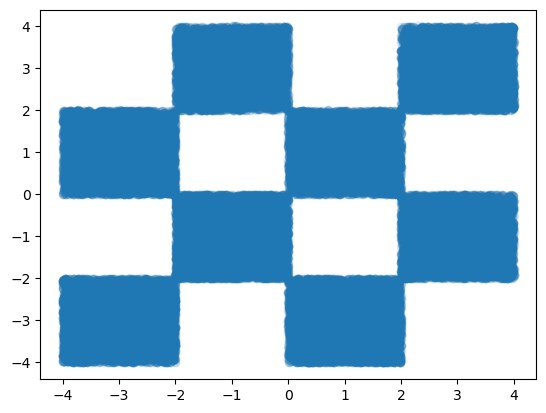

In [5]:
plt.plot(df_single_chain['x.1'], df_single_chain['x.2'], 'o', alpha=0.1)
plt.savefig('checkerboard_NUTS_1c.png', dpi=600)

In [6]:
fit_4_chain = stan_sampler.sample(num_chains=4, num_samples=(100_000/4))
df_4_chain = fit_4_chain.to_frame()
df_4_chain[['x.1','x.2']].to_csv('checkerboard_NUTS_4c.csv', index=False, header=False)
fit_4_chain1 = np.vstack((fit_4_chain._draws[-2, :, 0], fit_4_chain._draws[-1, :, 0]))
fit_4_chain2 = np.vstack((fit_4_chain._draws[-2, :, 1], fit_4_chain._draws[-1, :, 1]))
fit_4_chain3 = np.vstack((fit_4_chain._draws[-2, :, 2], fit_4_chain._draws[-1, :, 2]))
fit_4_chain4 = np.vstack((fit_4_chain._draws[-2, :, 3], fit_4_chain._draws[-1, :, 3]))

Sampling:   0%
Sampling:  25% (26000/104000)
Sampling:  50% (52000/104000)
Sampling:  75% (78000/104000)
Sampling: 100% (104000/104000)
Sampling: 100% (104000/104000), done.
Messages received during sampling:
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Rejecting initial value:
    Log probability evaluates to log(0), i.e. negative infinity.
    Stan can't start sampling from this initial value.
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation t

In [7]:
fit_4_chain1 = np.vstack((fit_4_chain._draws[-2, :, 0], fit_4_chain._draws[-1, :, 0]))
fit_4_chain2 = np.vstack((fit_4_chain._draws[-2, :, 1], fit_4_chain._draws[-1, :, 1]))
fit_4_chain3 = np.vstack((fit_4_chain._draws[-2, :, 2], fit_4_chain._draws[-1, :, 2]))
fit_4_chain4 = np.vstack((fit_4_chain._draws[-2, :, 3], fit_4_chain._draws[-1, :, 3]))

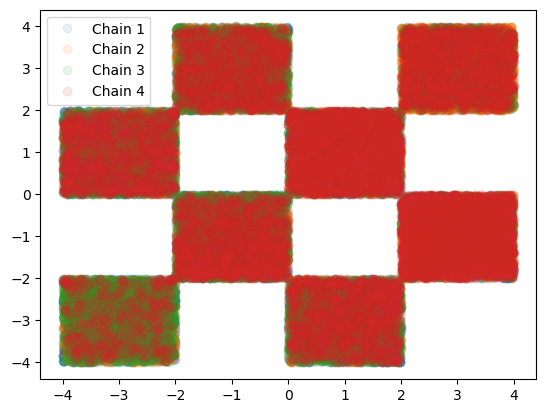

In [8]:
plt.plot(fit_4_chain1[0,:], fit_4_chain1[1,:], 'o', alpha=0.1, label="Chain 1")
plt.plot(fit_4_chain2[0,:], fit_4_chain2[1,:], 'o', alpha=0.1, label="Chain 2")
plt.plot(fit_4_chain3[0,:], fit_4_chain3[1,:], 'o', alpha=0.1, label="Chain 3")
plt.plot(fit_4_chain4[0,:], fit_4_chain4[1,:], 'o', alpha=0.1, label="Chain 4")
plt.legend()

plt.savefig('checkerboard_NUTS_4c.png', dpi=600)